In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Replace these with your actual database path and table name
db_path = 'C:/Users/Florian Stamer/runs/run_2025-01-12_17-48-56/db_2025-01-12_17-48-56.db'

table_name = 'Test_Results'





c:\ProgramData\Miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [30]:
# Set global font size to 9 pt
plt.rcParams.update({'font.size': 9})

# Optional: Improve plot aesthetics with seaborn
sns.set(style="whitegrid", font_scale=1.5)

In [4]:

# Connect to the SQLite database
try:
    conn = sqlite3.connect(db_path)
    print(f"Successfully connected to {db_path}")
except sqlite3.Error as e:
    print(f"Error connecting to database: {e}")
    raise  # Raises the exception to stop execution

# Query to select test_sequence and profit
query = f"SELECT test_sequence, profit FROM {table_name}"

try:
    # Read data into a pandas DataFrame
    df = pd.read_sql_query(query, conn)
    print("Data successfully retrieved from the database.")
except pd.io.sql.DatabaseError as e:
    print(f"Error reading data from database: {e}")
    conn.close()
    raise  # Raises the exception to stop execution

# Close the database connection
conn.close()

Successfully connected to C:/Users/Florian Stamer/runs/run_2025-01-12_17-48-56/db_2025-01-12_17-48-56.db
Data successfully retrieved from the database.


In [ ]:
# Drop rows with NULL test_sequence or profit
df = df.dropna(subset=['test_sequence', 'profit'])

Processed test_sequence to compute sequence_length.


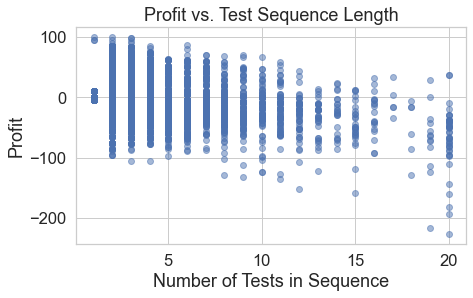

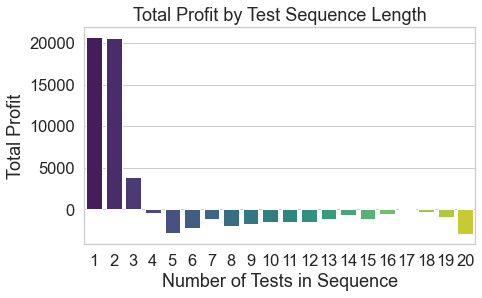

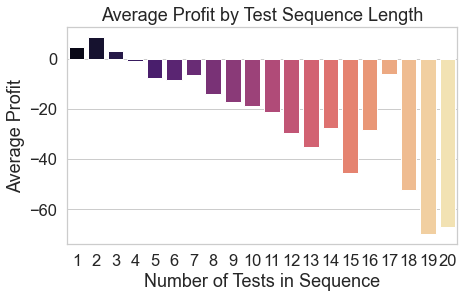

In [ ]:


# Process the test_sequence to compute the number of tests
df['sequence_length'] = df['test_sequence'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

print("Processed test_sequence to compute sequence_length.")

# Option 1: Histogram of sequence lengths colored by profit (e.g., using a scatter plot)
plt.figure(figsize=(7,4))
scatter = plt.scatter(df['sequence_length'], df['profit'], alpha=0.5)
plt.title('Profit vs. Test Sequence Length')
plt.xlabel('Number of Tests in Sequence')
plt.ylabel('Profit')
plt.grid(True)
plt.savefig('images/profit_vs_sequence_length.svg', format='svg', bbox_inches='tight')
plt.show()

# Option 2: Histogram where the bins represent sequence lengths and the height represents total profit
# You can choose to aggregate profit by sum, mean, etc.

# Example: Sum of profit per sequence length
profit_sum = df.groupby('sequence_length')['profit'].sum().reset_index()

plt.figure(figsize=(7,4))
sns.barplot(x='sequence_length', y='profit', data=profit_sum, palette='viridis')
plt.title('Total Profit by Test Sequence Length')
plt.xlabel('Number of Tests in Sequence')
plt.ylabel('Total Profit')
plt.savefig('images/total_profit_by_sequence_length.svg', format='svg', bbox_inches='tight')

plt.show()

# Example: Average profit per sequence length
profit_mean = df.groupby('sequence_length')['profit'].mean().reset_index()

plt.figure(figsize=(7,4))
sns.barplot(x='sequence_length', y='profit', data=profit_mean, palette='magma')
plt.title('Average Profit by Test Sequence Length')
plt.xlabel('Number of Tests in Sequence')
plt.ylabel('Average Profit')
plt.savefig('images/average_profit_by_sequence_length.svg', format='svg', bbox_inches='tight')

plt.show()

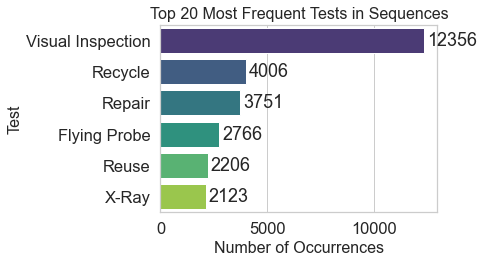

In [35]:
from collections import Counter
# Split the 'test_sequence' column by commas to create a list of tests for each row
df['test_list'] = df['test_sequence'].str.split(',')

# Flatten the list of lists into a single list containing all tests
# Also, strip any leading/trailing whitespace from each test name
all_tests = [test.strip() for sublist in df['test_list'] for test in sublist if isinstance(test, str)]

# Step 2: Count the Frequency of Each Test
# ----------------------------------------
# Use Counter to tally the occurrences of each test
test_counts = Counter(all_tests)

# Convert the Counter object to a DataFrame for easier manipulation
test_counts_df = pd.DataFrame.from_dict(test_counts, orient='index', columns=['count']).reset_index()
test_counts_df = test_counts_df.rename(columns={'index': 'test'})

# Sort the DataFrame by 'count' in descending order
test_counts_df = test_counts_df.sort_values(by='count', ascending=False)

# Optional: Display only the top N tests for better readability
top_n = 20  # You can adjust this value as needed
top_tests_df = test_counts_df.head(top_n)

# Step 3: Plot the Bar Chart
# --------------------------
plt.figure(figsize=(7, 4))  # Adjust the figure size as needed

# Create a horizontal bar chart for better readability of test names
sns.barplot(x='count', y='test', data=top_tests_df, palette='viridis')

# Add titles and labels
plt.title(f'Top {top_n} Most Frequent Tests in Sequences', fontsize=16)
plt.xlabel('Number of Occurrences', fontsize=16)
plt.ylabel('Test', fontsize=16)

# Optional: Add count labels to each bar for clarity
for index, value in enumerate(top_tests_df['count']):
    plt.text(value + max(top_tests_df['count']) * 0.01, index, str(value), va='center')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('images/test_occurrence_frequency.svg', format='svg', bbox_inches='tight')

plt.show()

,test,total_profit
2,Repair,28126.0
1,Recycle,17849.0
0,Flying Probe,7939.0
5,X-Ray,-11550.0
3,Reuse,-21039.0
4,Visual Inspection,-21670.0


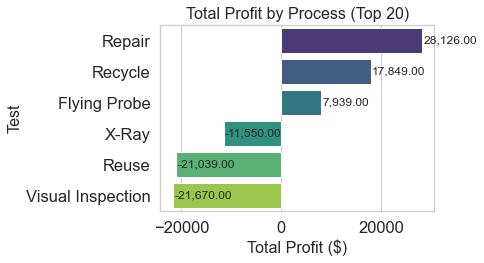

In [37]:
# Step 1: Split 'test_sequence' into lists and remove duplicates within each sequence
df['unique_tests'] = df['test_sequence'].str.split(',').apply(lambda tests: set([test.strip() for test in tests if isinstance(test, str)]))

# Step 2: Explode the 'unique_tests' so each test has its own row
df_exploded = df.explode('unique_tests')

# Rename 'unique_tests' to 'test' for clarity
df_exploded = df_exploded.rename(columns={'unique_tests': 'test'})

# Step 3: Group by 'test' and sum the 'profit' to get total profit per test
test_profit = df_exploded.groupby('test')['profit'].sum().reset_index()

# Rename columns for clarity
test_profit = test_profit.rename(columns={'profit': 'total_profit'})

# Sort the DataFrame by 'total_profit' in descending order
test_profit = test_profit.sort_values(by='total_profit', ascending=False)

# Display the aggregated DataFrame (top 20 tests)
display(test_profit.head(20))

# Step 4: Plot the Bar Chart of Total Profit by Test

# Define the number of top tests to display for clarity
top_n = 20  # Adjust this value as needed

# Select the top N tests
top_tests_df = test_profit.head(top_n)

# Create the bar chart
plt.figure(figsize=(7, 4))  # Adjust the figure size as needed

sns.barplot(
    x='total_profit',
    y='test',
    data=top_tests_df,
    palette='viridis'
)

# Add titles and labels
plt.title(f'Total Profit by Process (Top {top_n})', fontsize=16)
plt.xlabel('Total Profit ($)', fontsize=16)
plt.ylabel('Test', fontsize=16)

# Optional: Add profit labels next to each bar for clarity
for index, value in enumerate(top_tests_df['total_profit']):
    plt.text(
        value + top_tests_df['total_profit'].max() * 0.01,  # Position text slightly to the right of the bar
        index,  # y-position (row)
        f'{value:,.2f}',  # Formatted profit value
        va='center',  # Vertical alignment
        fontsize=12
    )

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('images/total_profit_by_test.svg', format='svg', bbox_inches='tight')

plt.show()